## Get the data

In [1]:
import Ngl, Nio
import os, numpy, csv, json
from IPython.display import Image
from shapely.geometry import Polygon, Point
import geopandas

CWD = os.getcwd()

mask_file = CWD+'/../../data/Figure_12.9/mask_80perc-agreement_SWE_panel_b_RCP85_mce_minus_baseline.nc'
ncfile = CWD+'/../../data/Figure_12.9/SWE_panel_b_RCP85_mce_minus_baseline.nc'
model_mask = CWD+'/../../data/Figure_12.9/EUROPE_raw_common_grid.nc'


#----------------------------------------------------------------------
#  Add the trajectory lines.
#----------------------------------------------------------------------
def retrieve_AR6regions_for_region(region_name):

    regions_filename=CWD+'/../../scripts/ATLAS/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv'

    # -- Store the informations by region in the 'regions' dictionary
    regions = dict()
    with open(regions_filename) as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
        for row in spamreader:
            #if row[0]==region_name:
            if region_name in row[0]:
                region_dict = dict()
                lats_vect = []
                lons_vect = []
                tmp_polygon_vertices = []
                for vertice in row[4:-1]:
                    if vertice:
                        dum = vertice.split('|')
                        lons_vect.append(float(dum[0]))
                        lats_vect.append(float(dum[1]))
                        tmp_polygon_vertices.append( (float(dum[0]), float(dum[1])) )
                region_dict['polygon'] = Polygon(tmp_polygon_vertices)
                region_dict['lons_vect'] = lons_vect
                region_dict['lats_vect'] = lats_vect
                #
                regions[row[3]] = region_dict
    #
    return regions


#
def add_AR6regions(wks, base_map, regions):
    #
    txres                       = Ngl.Resources()  
    txres.txFontHeightF         = 0.022
    txres.txFont = 22
    
    gsres                   = Ngl.Resources()
    # Polyline resources.
    gsres.gsLineColor       = "Black"
    gsres.gsLineThicknessF  = 3.0      # thrice thickness

    adjp = dict(
        NEU = dict(lon=-15, lat=0),
        WCE = dict(lon=-15, lat=-2.5),
        MED = dict(lon=-15, lat=0),
        EEU = dict(lon=5, lat=-3),
    )
    
    for subregion in regions:
        lons_vect = regions[subregion]['lons_vect']
        lats_vect = regions[subregion]['lats_vect']
        # Draw a text string labeling the marker
        lonp = numpy.mean(lons_vect)
        latp = numpy.mean(lats_vect)
        print subregion, lonp, latp
        if subregion in adjp:
            lonp += adjp[subregion]['lon']
            latp += adjp[subregion]['lat']
        Ngl.add_text(wks,base_map, subregion, lonp, latp, txres)

        # -- Close the polygon
        lons_vect.append(lons_vect[0])
        lats_vect.append(lats_vect[0])
        poly1 = Ngl.add_polyline(wks,base_map,lons_vect,lats_vect,gsres)

    return


def create_SWE_map(wks, ncfile, model_mask, region_dict, title):
    
    fmask_model = Nio.open_file(model_mask)
    mask_dat  = fmask_model.variables["lsmmask"][:,:]

    f    = Nio.open_file(ncfile)
    dat  = f.variables["snw"][0,:,:] * mask_dat
    lat  = f.variables["lat"][:]
    lon  = f.variables["lon"][:]
    

    cnres                 = Ngl.Resources()
    cnres.nglDraw  = False
    cnres.nglFrame = False
    cnres.nglMaximize = False

    # Contour resources
    cnres.cnFillOn        = True
    cnres.cnLevelSelectionMode = "ExplicitLevels"
    cnres.cnLevels    = [-40, -20, -10, -5, -1, 1, 5, 10, 20, 40]
    
    cryo_div_21_raw = [
        [38,  38,  0],
        [58,  58,  18],
        [80,  80,  35],
        [104, 104, 55],
        [129, 129, 75],
        [154, 154, 97],
        [180, 180, 122],
        [203, 203, 153],
        [219, 219, 183],
        [233, 233, 213],
        [234, 238, 235],
        [209, 220, 230],
        [179, 197, 215],
        [148, 174, 199],
        [119, 151, 183],
        [90,  129, 168],
        [62,  107, 152],
        [43,  85,  134],
        [40,  64,  114],
        [42,  44,  95],
        [43,  25,  76]]
    # -- reverse the palette
    
    test = []
    for elt in cryo_div_21_raw:
        tmp = []
        for eelt in elt:
            tmp.append(eelt/256.)
        tmp.append(1.)
        test.append(tmp)
    cryo_div_21 = numpy.array(test)

    cnres.cnFillPalette   = cryo_div_21      # New in PyNGL 1.5.0
    cnres.cnLinesOn       = True
    cnres.cnLineLabelsOn  = False
    cnres.cnRasterSmoothingOn = False

    # Labelbar resource
    cnres.lbOrientation   = "horizontal"
    cnres.lbBoxEndCapStyle= "TriangleBothEnds"
    cnres.lbLabelFontHeightF = 0.018
    cnres.pmLabelBarOrthogonalPosF = 0.02
    cnres.pmLabelBarWidthF = 0.6
    cnres.pmLabelBarHeightF = 0.1 #0.15

    # Scalar field resources
    cnres.sfXArray        = lon
    cnres.sfYArray        = lat

    # Map resources
    cnres.mpFillOn               = True
    cnres.mpFillDrawOrder        = "PostDraw"
    cnres.mpLandFillColor        = "Transparent"
    cnres.mpOceanFillColor       = "white"
    cnres.mpInlandWaterFillColor = "white"
    cnres.mpGridAndLimbOn      =  False                  #-- don't draw grid lines
    cnres.mpLimitMode = "LatLon"
    
    cnres.mpMaxLatF   = region_dict['latmax']           # select subregion
    cnres.mpMinLatF   = region_dict['latmin']
    cnres.mpMinLonF   = region_dict['lonmin']
    cnres.mpMaxLonF   = region_dict['lonmax']
    # Remove box around plot
    cnres.lbLabelBarOn = True

    # Remove Lon/lat ticks
    cnres.tmXBOn = False
    cnres.tmYLOn = False
    cnres.tmXTOn = False
    cnres.tmYROn = False

    # Titles
    cnres.tiMainString = title
    
    return Ngl.contour_map(wks,dat,cnres), cnres, dat


def create_shading_layer(wks, mask_file, model_mask, region_dict, title):
    
    fmask_model = Nio.open_file(model_mask)
    mask_dat  = fmask_model.variables["lsmmask"][:,:]

    f    = Nio.open_file(mask_file)
    dat  = f.variables["snw"][0,:,:] * mask_dat
    lat  = f.variables["lat"][:]
    lon  = f.variables["lon"][:]

    cnres                 = Ngl.Resources()
    cnres.nglDraw  = False
    cnres.nglFrame = False
    cnres.nglMaximize = False
    #
    cnres.gsnShadeFillType = "pattern"
    cnres.gsnShadeHigh     = 1

    # Contour resources
    cnres.cnFillOn        = True
    cnres.cnMonoFillPattern = False
    cnres.cnFillPatterns = [3,-1]
    cnres.cnLevelSelectionMode='ExplicitLevels'
    cnres.cnLevels = [0.9]
    cnres.cnLinesOn       = False
    cnres.cnLineLabelsOn  = False
    cnres.cnFillColors      = [ 1, 1]
    cnres.cnFillScales      = [ 0.9, 2]

    # Scalar field resources
    cnres.sfXArray        = lon
    cnres.sfYArray        = lat

    # Map resources
    cnres.mpFillOn               = False
    cnres.mpGridAndLimbOn      =  False                  #-- don't draw grid lines
    
    cnres.mpLimitMode = "LatLon"
    cnres.mpMaxLatF   = region_dict['latmax']           # select subregion
    cnres.mpMinLatF   = region_dict['latmin']
    cnres.mpMinLonF   = region_dict['lonmin']
    cnres.mpMaxLonF   = region_dict['lonmax']
    # Remove box around plot
    cnres.pmTickMarkDisplayMode = "Never"
    cnres.lbLabelBarOn = False

    # Remove Lon/lat ticks
    cnres.tmXBOn = False
    cnres.tmYLOn = False
    cnres.tmXTOn = False
    cnres.tmYROn = False

    # Titles
    cnres.tiMainString = title
    
    return Ngl.contour_map(wks,dat,cnres)


    
def layer_AR6_regions(wks, cnres):
    cnres2                 = cnres
    # Contour resources
    cnres2.cnFillOn        = False

    # Map resources
    cnres2.mpFillOn               = False
    return Ngl.map(wks,cnres2)
    



scenario = 'RCP85'
horizon = '2050'
region_dict = dict(name='EUROPE',
                    lonmin = -15,
                    lonmax = 65,
                    latmin = 25,
                    latmax = 75,
                   )

outfilename='SWE_test'

#wks_type = "png"
wks_type = "pdf"

wks = Ngl.open_wks(wks_type, outfilename)

wmap, cnres, dat = create_SWE_map(wks, ncfile, model_mask, region_dict, ' ')
shading_map = create_shading_layer(wks, mask_file, model_mask, region_dict, ' ')

# -- Add the AR6 regions
# -- Extract the subregions of the region
regions = retrieve_AR6regions_for_region(region_dict['name'])

add_AR6regions(wks, shading_map, regions)

Ngl.overlay(wmap, shading_map)#, wmap_empty) 

Ngl.draw(wmap)
Ngl.draw(shading_map)

txres                       = Ngl.Resources()  
txres.txFontHeightF         = 0.02

# Draw a text string labeling the marker
Ngl.text_ndc(wks,"Change in # days with SWE>100mm",0.5,0.75,txres)
Ngl.text_ndc(wks,"CORDEX EUR-11 - RCP8.5 2050",0.5,0.71,txres)



Ngl.frame(wks)

Ngl.end()

#Image(outfilename+'.png')

EEU 50.0 55.0
MED 15.0 37.5
NEU 15.0 63.625
WCE 15.0 49.825


## PDF

In [2]:
variable = 'SWE'
trim_figure = CWD+'/../../figs/Figure_12.9/panel_b_'+variable+'_map_RCP85_2050.pdf'

cmd = 'pdfcrop '+outfilename+'.pdf '+ trim_figure
print cmd
os.system(cmd)

pdfcrop SWE_test.pdf /home/jservon/Chapter12_IPCC/figs/Figure_12.9/panel_b_SWE_map_RCP85_2050.pdf


0

EEU 50.0 55.0
MED 15.0 37.5
NEU 15.0 63.625
WCE 15.0 49.825


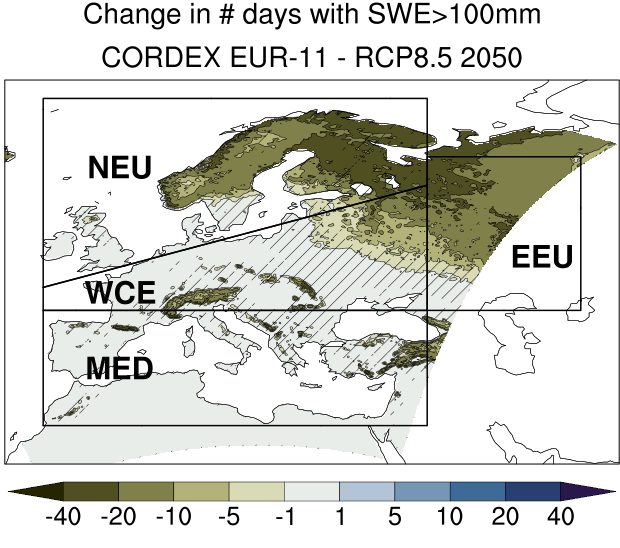

In [1]:
# -- Trim the figure and extract the colorbar
# -----------------------------------------------
from PIL import Image as PILImage

def extract_plot(figure_file,trim_figure) :
    im = PILImage.open(figure_file)
    im_crop = im.crop((200, 240, 820, 770))
    im_crop.save(trim_figure, quality=95)


# -- color bar file
variable = 'SWE'
trim_figure = CWD+'/../../figs/Figure_12.9/panel_b_'+variable+'_map_RCP85_2050.png'
# -- Extract the colorbar
extract_plot(outfilename+'.png',trim_figure)
Image(trim_figure)